In [1]:
%load_ext autoreload
%autoreload 2

from collections import defaultdict, Counter
from functools import partial, reduce
from itertools import chain, cycle
from multiprocessing import Pool, cpu_count
import os
from pathlib import Path
import random
import yaml

from Bio.PDB.Polypeptide import three_to_one
import h5py
import numpy as np
import numexpr
import pandas as pd
import scipy.stats as stats

from scipy.spatial.distance import jensenshannon, cdist
from sklearn.preprocessing import MinMaxScaler

import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display_html
from tqdm import tqdm

from scripts.attribution import upsample
from scripts.general import analysis, data


tqdm.pandas(desc='Pandas op')
MAX_PROC = cpu_count() - 2
numexpr.set_num_threads(MAX_PROC)

%load_ext rpy2.ipython

plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 14

RendererRegistry.enable('html')

## Load data

In [2]:
with open('experiment_config.yaml', 'r') as config_file:
    config = yaml.load(config_file, Loader=yaml.FullLoader)
    
seq_data = data.load_seq_and_abundance_data(config)[
    ['swissprot_ac', 'seq', 'Systematic_Name', 'Standard_Name', 'Median_molecules_per_cell']
]
seq_data = seq_data.assign(seq_len = seq_data['seq'].str.len())
seq_data = seq_data.assign(
    abundance_bin = pd.qcut(seq_data['Median_molecules_per_cell'], q = 10, labels=range(1, 11))
)

sequence_of_prot_id = dict(seq_data[['swissprot_ac', 'seq']].values)

In [3]:
with h5py.File('seq_orderings.h5', 'r') as store:
    prot_ids = list(store.keys())
    orderings = [np.array(store[prot_id], dtype=np.float32)
                 for prot_id in store.keys()]

prot_ordering = dict(zip(prot_ids, orderings))

In [4]:
seq_data = seq_data.assign(
    ordering = seq_data['swissprot_ac'].map(prot_ordering.get)
)

seq_data = seq_data.assign(
    ordering_rank = seq_data['ordering'].map(np.argsort) / seq_data['seq_len']
)

seq_data = seq_data.assign(
    ordering_zscore = seq_data['ordering_rank'].map(stats.zscore)
)

## Overview ordering values across sequence length

In [5]:
seq_data['seq_len'].median(), seq_data['seq_len'].mean()

(394.0, 430.02947368421053)

<AxesSubplot:xlabel='seq_len', ylabel='Count'>

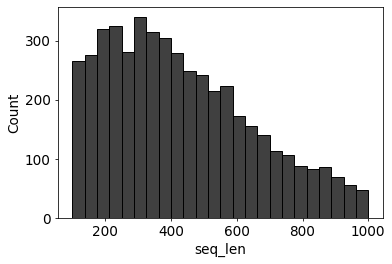

In [6]:
plt.figure(dpi=70, figsize=(6, 4))

sns.histplot(data = seq_data, x = 'seq_len', color = 'k')

In [7]:
MIN_LEN = 200
MAX_LEN = 400

seq_data_all = seq_data.query('seq_len > 0')
seq_data = seq_data.query(f'{MIN_LEN} <= seq_len <= {MAX_LEN}')

seq_data.shape[0]

1691

In [8]:
seq_data = seq_data.assign(
    upsampled_ordering = seq_data['swissprot_ac'].map(
        lambda prot_id: upsample(prot_ordering[prot_id], max_len=MAX_LEN)
    )
)

seq_data = seq_data.assign(
    upsampled_ordering_zscore = seq_data['upsampled_ordering'].map(stats.zscore),
)

seq_data = seq_data.assign(
    upsampled_rank = seq_data['ordering_rank'].map(lambda ranking: upsample(ranking, max_len=MAX_LEN)),
    upsampled_zscore = seq_data['ordering_zscore'].map(lambda ranking: upsample(ranking, max_len=MAX_LEN)),
)

upsampled_orderings = np.vstack(seq_data['upsampled_ordering'])

In [9]:
upsampled_orderings.shape

(1691, 400)

### Position-wise ordering rank

Because the UMAP projection is distorting, the most important relationship between ordering values of residues in a sequence is their relative order, so use their argsort values normalized by sequence length.

In [10]:
upsampled_ranks = np.vstack(seq_data['upsampled_rank'].values)
upsampled_ranks_zscore = np.vstack(seq_data['upsampled_zscore'].values)

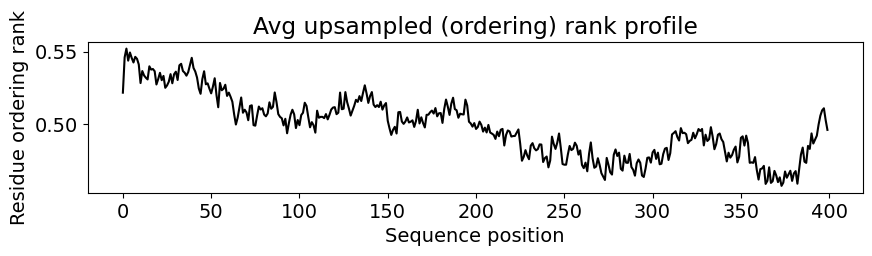

In [11]:
plt.figure(figsize=(10, 2))
        
plt.plot(upsampled_ranks.mean(axis=0), color = 'k')

plt.xlabel('Sequence position')
plt.ylabel('Residue ordering rank')
_ = plt.title('Avg upsampled (ordering) rank profile')


plt.savefig('mean_ordering_profile.pdf')

## Cluster ordering profiles

Text(28.222222222222214, 0.5, 'Sequence')

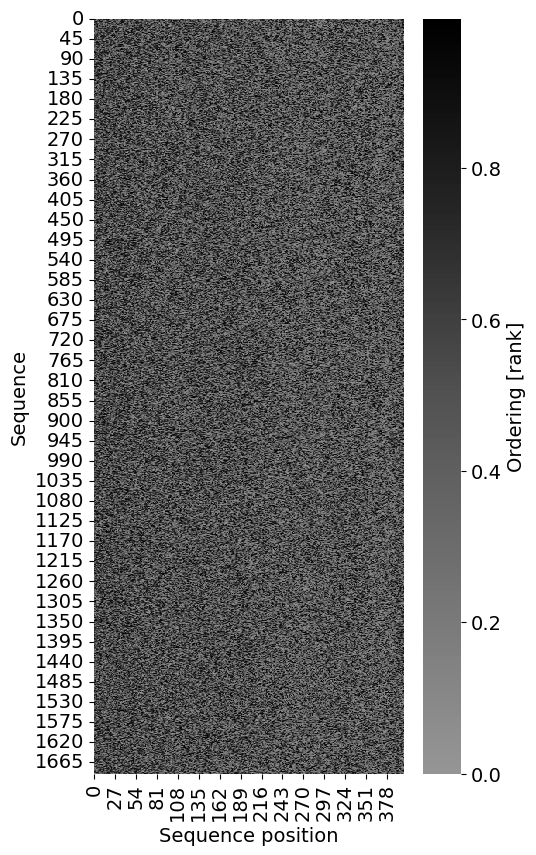

In [12]:
plt.figure(figsize=(5, 10))

sns.heatmap(
    upsampled_ranks, 
    cbar_kws={'label': 'Ordering [rank]'}, 
    cmap='Greys',
    center=0
)

plt.xlabel('Sequence position')
plt.ylabel('Sequence')

In [13]:
from sklearn.decomposition import PCA

pca_fitting = PCA()
pca_reduction = pca_fitting.fit_transform(upsampled_ranks)

(0.0, 50.0)

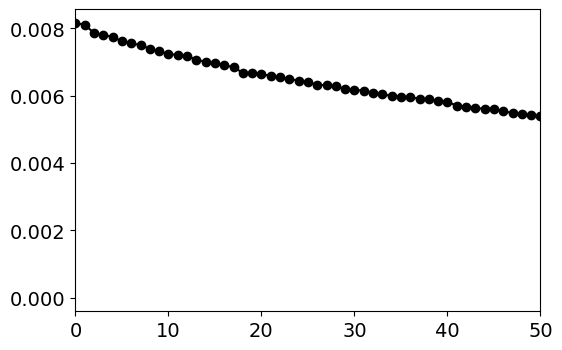

In [14]:
plt.figure(dpi=100, figsize=(6, 4))
plt.rcParams['font.size'] = 14

plt.plot(pca_fitting.explained_variance_ratio_ , 'o-', color = 'k')
plt.xlim(0, 50)

In [18]:
from sklearn.cluster import KMeans

kmeans_clusters = KMeans(n_clusters=2, random_state=42).fit_predict(upsampled_ranks)

seq_data = seq_data.assign(
    cluster_num = kmeans_clusters
)

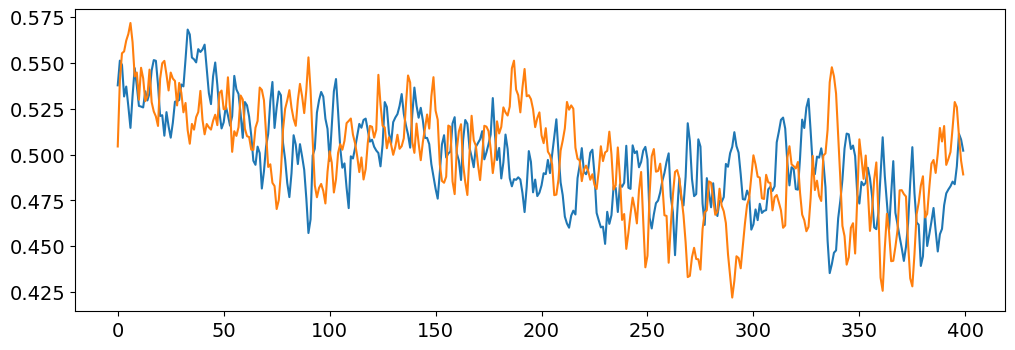

In [19]:
plt.figure(figsize=(12, 4))

for i in range(0, kmeans_clusters.max() + 1):
    plt.plot(upsampled_ranks[kmeans_clusters == i].mean(axis = 0))

# plt.hlines(y=[-1, 1], xmin=0, xmax=MAX_LEN, color='r')

In [20]:
stats.pearsonr(
    upsampled_ranks[kmeans_clusters == 0].mean(axis = 0),
    upsampled_ranks[kmeans_clusters == 1].mean(axis = 0)
)

(0.21838103562138006, 1.0468678342380767e-05)

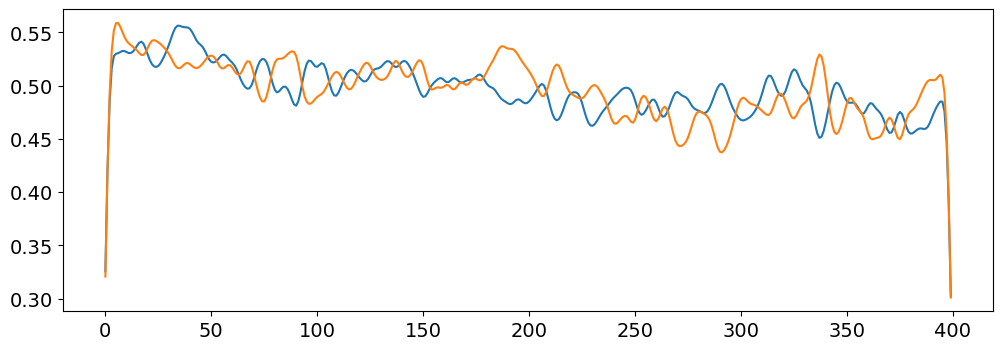

In [21]:
from astropy.convolution import Gaussian1DKernel
from astropy.convolution import convolve


kernel = Gaussian1DKernel(stddev=2)


plt.figure(figsize=(12, 4))

for i in range(0, kmeans_clusters.max() + 1):
    plt.plot(convolve(upsampled_ranks[kmeans_clusters == i].mean(axis = 0),
                      kernel)
            )

<AxesSubplot:xlabel='log_Median_molecules_per_cell', ylabel='Density'>

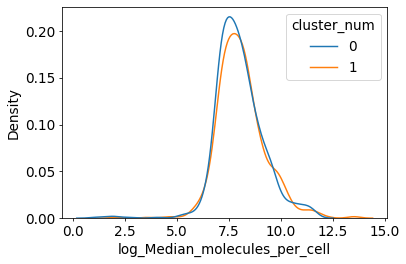

In [22]:
plt.figure(dpi=70, figsize=(6, 4))

sns.kdeplot(
    data = seq_data.assign(log_Median_molecules_per_cell = np.log(seq_data['Median_molecules_per_cell'])),
    x = 'log_Median_molecules_per_cell',
    hue = 'cluster_num'
)